Example of script to make a violin plot of number of UMI per spot.<br>

Input files are downsampled.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10015CN45_C1_downsamp_stdata.tsv <br>
10015CN45_D1_downsamp_stdata.tsv <br>
10015CN45_E1_downsamp_stdata.tsv <br>
10015CN45_C2_downsamp_stdata.tsv <br>
10015CN45_D2_downsamp_stdata.tsv <br>
10015CN45_E2_downsamp_stdata.tsv <br>
10015CN45_C1_stdata_under_tissue_spots.txt <br>
10015CN45_D1_stdata_under_tissue_spots.txt <br>
10015CN45_E1_stdata_under_tissue_spots.txt <br>
10015CN45_C2_stdata_under_tissue_spots.txt <br>
10015CN45_D2_stdata_under_tissue_spots.txt <br>
10015CN45_E2_stdata_under_tissue_spots.txt <br>

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.patches as mpatches
import statistics
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['index'] in ['10015CN45_C2', '10015CN45_D2', '10015CN45_E2']:
        return condition[0]
        
    elif row['index'] in ['10015CN45_C1', '10015CN45_D1', '10015CN45_E1']:
        return condition[1]

In [4]:
# Make a sample-condition dictionary
sam_cond = {'ST': ['10015CN45_C1', '10015CN45_D1', '1001CN45_E1'],
           'sm-omics':['10015CN45_C2', '10015CN45_D2', '10015CN45_E2']}



In [5]:
'Reads in tsv counts files'
path = '../../smomics_data/'

samples_list = ['10015CN45_C1', '10015CN45_D1', '10015CN45_E1', '10015CN45_C2', '10015CN45_D2', '10015CN45_E2']

files_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_downsamp_stdata.tsv'), sep = '\t', index_col=0)
    files_dict[filename] = file.T


In [18]:
'Splits counts file to inside vs outside tissue'
genes_under_tissue_dict = {}
    
for filename in samples_list:
    
    file = pd.read_csv(os.path.join(path, filename + '_stdata_under_tissue_spots.txt'), sep = '\t', index_col=0)
    
    spot_coord = list()
    
    for spots in list(file):
        spots_tmp = spots.split('_')
        new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
        spot_coord.append(new_spot_coord)

    genes_under_tissue_dict[filename] = spot_coord

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(genes_under_tissue_dict[k])
    v_under_tissue = v[genes_under_tissue_dict[k]]
    v_under_tissue = v_under_tissue.loc[:,~v_under_tissue.columns.duplicated()]
    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    v_outside_tissue = v[spots_outside_tissue] 
    v_outside_tissue = v_outside_tissue.loc[:,~v_outside_tissue.columns.duplicated()]
    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]
    
    print(len(v_under_tissue.columns))
    print(len(v_outside_tissue.columns))

322
685
341
666
342
665
335
672
344
663
340
667


In [8]:
'Collects average gene and UMI counts inside vs. outside tissue in a dataframe'
# Filter on sequencing depth
seq_depth = {'10015CN45_C1':[26732186, 26],
            '10015CN45_D1':[25018198, 25],
            '10015CN45_E1':[24573068, 25],
            '10015CN45_C2':[25267156, 25],
            '10015CN45_D2':[25726826, 26],
            '10015CN45_E2': [25429633, 25]}

gene_dict = {}
umi_dict = {}
values_dict = {}
all_values = []
all_values_genes = []
total_counts_dict = {}
total_genes_dict = {}
for key, value in files_underoutside_tissue_dict.items():
    print(key)
    for i, val in enumerate(value): # [inside/outside] of tissue  
    
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)

        # # Remove genes (rows) where the total sum is less than xx
        value_red = val[val['tot count'] > seq_depth[key][1]]

        # Remove tot count column
        value_red.drop(['tot count'], axis = 1, inplace=True)
            
        if i == 0: # inside tissue
            # collect summarized data
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key] = [genes_per_spot]
            umi_dict[key] = [umis_per_spot]          
            
            # collect data for norm test
            values_dict[key] = [value_red.sum(axis = 0)]
            print(umis_per_spot)
            
            # collect all umi values for plotting
            tmpvalues = pd.DataFrame(value_red.sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'UMIs inside'
            all_values.append(tmpvalues)
            
            # collect all gene values for plotting
            tmpvalues = pd.DataFrame(value_red.astype(bool).sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'Genes inside'
            all_values_genes.append(tmpvalues)
            
            # collect total counts data for plotting
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key] = [total_counts]
            total_genes_dict[key] = [total_genes]
            
        elif i == 1: # outside tissue
            # collect summarized data
            genes_per_spot = value_red.astype(bool).sum(axis = 0).mean()
            umis_per_spot = value_red.sum(axis = 0).mean()
            gene_dict[key].append(genes_per_spot)
            umi_dict[key].append(umis_per_spot)

            # collect data for norm test
            values_dict[key].append(value_red.sum(axis = 0))
            
            # collect all umi values for plotting
            tmpvalues = pd.DataFrame(value_red.sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'UMIs outside'
            all_values.append(tmpvalues)
            
            # collect all gene values for plotting
            tmpvalues = pd.DataFrame(value_red.astype(bool).sum(axis = 0))
            tmpvalues.columns = ['value']
            tmpvalues['index'] = key
            tmpvalues['variable'] = 'Genes outside'
            all_values_genes.append(tmpvalues)
            
            # collect total counts data for plotting
            total_counts = sum(value_red.sum(axis = 1))
            total_genes = value_red.astype(bool)[value_red.astype(bool).any(axis=1)].count(axis = 0)[0]
            total_counts_dict[key].append(total_counts)
            total_genes_dict[key].append(total_genes)

# Make dataframe out of dict
df = pd.DataFrame.from_dict(gene_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_umi = pd.DataFrame.from_dict(umi_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi['Condition'] = df_umi.apply(lambda row: condition(row), axis=1)
df_umi_total = pd.DataFrame.from_dict(total_counts_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
df_umi_total['Condition'] = df.apply(lambda row: condition(row), axis=1)
df_genes_total = pd.DataFrame.from_dict(total_genes_dict, orient='index', columns=['Genes inside', 'Genes outside']).reset_index()
df_genes_total['Condition'] = df.apply(lambda row: condition(row), axis=1)

# Prepare for plotting
dfplot = pd.melt(df, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])
dfplot_umi = pd.melt(df_umi, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_umi_total = pd.melt(df_umi_total, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])
df_genes_total = pd.melt(df_genes_total, id_vars=['index', 'Condition'], value_vars = ['Genes inside', 'Genes outside'])

# collect data for checking distribution 
ls = pd.DataFrame.from_dict(values_dict, orient='index', columns=['UMIs inside', 'UMIs outside']).reset_index()
ls['Condition'] = ls.apply(lambda row: condition(row), axis=1)
ls_melt = pd.melt(ls, id_vars=['index', 'Condition'], value_vars = ['UMIs inside', 'UMIs outside'])

# collect all umis per spot
all_df_umi = pd.concat(all_values)
all_df_umi['Condition'] = all_df_umi.apply(lambda row: condition(row), axis=1)

# collect all genes per spot
all_df_genes = pd.concat(all_values_genes)
all_df_genes['Condition'] = all_df_genes.apply(lambda row: condition(row), axis=1)


10015CN45_C1
6386.614906832298
10015CN45_D1
3982.706744868035
10015CN45_E1
6489.652046783625
10015CN45_C2
18528.25671641791
10015CN45_D2
24542.654069767443
10015CN45_E2
16554.779411764706


In [16]:
dfplot

,index,Condition,variable,value
0,10015CN45_C1,ST,Genes inside,3163.034161
1,10015CN45_D1,ST,Genes inside,2323.278592
2,10015CN45_E1,ST,Genes inside,3243.277778
3,10015CN45_C2,sm-omics,Genes inside,5430.382090
4,10015CN45_D2,sm-omics,Genes inside,6074.287791
5,10015CN45_E2,sm-omics,Genes inside,5203.841176
6,10015CN45_C1,ST,Genes outside,1759.214599
7,10015CN45_D1,ST,Genes outside,1218.186186
8,10015CN45_E1,ST,Genes outside,1795.087218
9,10015CN45_C2,sm-omics,Genes outside,1060.677083


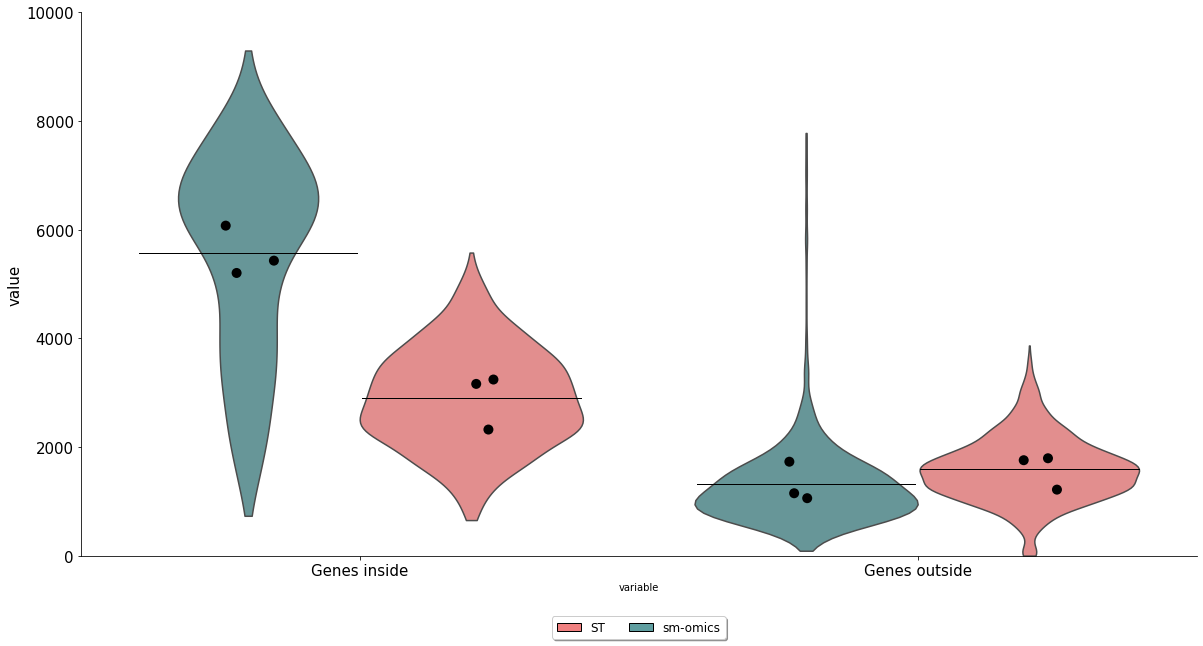

In [9]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot

ax = sns.stripplot(x=x, y=y, data=data,  hue=hue, dodge=True, hue_order = ['sm-omics', 'ST',], order = ['Genes inside', 'Genes outside'], palette = [ 'black','black',],size=10)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Genes per spot (mean)", fontsize=15)
ax.set_ylim([0,10000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('Genes inside','sm-omics'), ('Genes inside','visium')),
               (('Genes outside','sm-omics'), ('Genes outside','visium'))]

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x,
            y=y,
            data=data,
            hue=hue,
            hue_order = ['sm-omics', 'ST',], 
            order = ['Genes inside', 'Genes outside'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

sns.violinplot(x=x, 
                    y=y, 
                    data=all_df_genes, 
                    hue=hue, 
                    hue_order = ['sm-omics', 'ST',], 
                    order = ['Genes inside', 'Genes outside'], 
                    palette = [ 'cadetblue','lightcoral',], 
                    cut=0,
                   inner = None)

# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['sm-omics', 'ST',]
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='lightcoral', label=labels2[1], edgecolor='k')
outside_patch= mpatches.Patch( facecolor='cadetblue', label=labels2[0], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_Genes_Cancer.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [10]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable             
ST        Genes inside   2910.0
          Genes outside  1591.0
sm-omics  Genes inside   5570.0
          Genes outside  1315.0

In [11]:
data.groupby(['Condition', 'variable']).std().round()

value
Condition variable            
ST        Genes inside   510.0
          Genes outside  323.0
sm-omics  Genes inside   452.0
          Genes outside  364.0

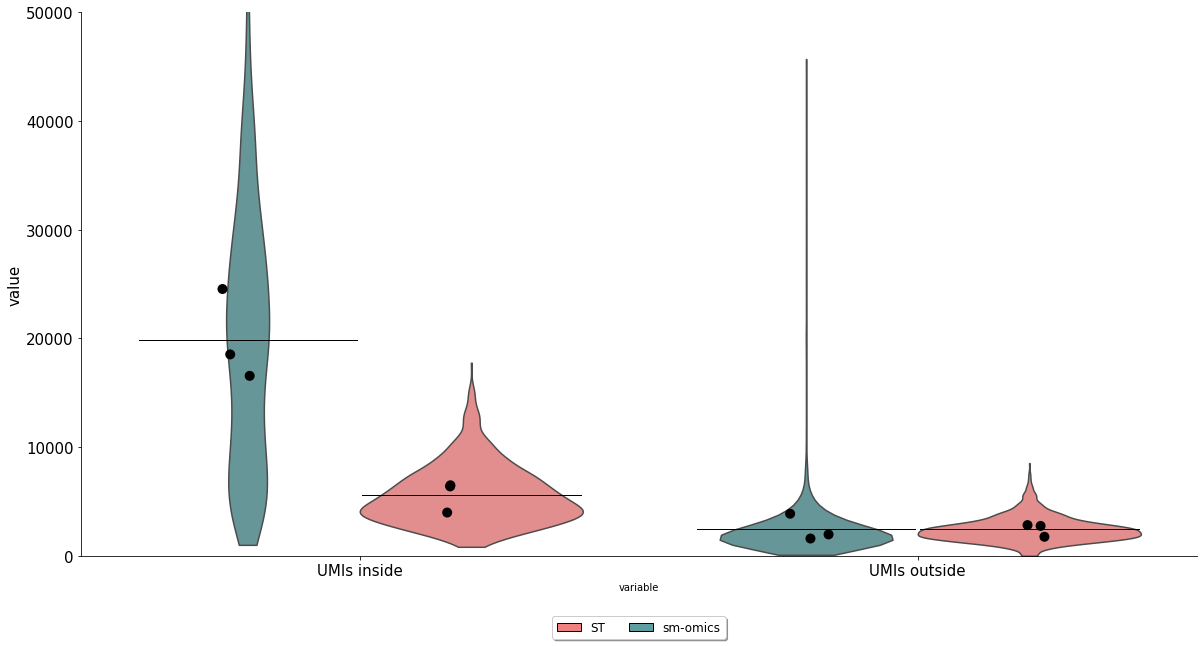

In [13]:
'Plots violin plots inside vs. outside tissue: Genes'
fig = plt.figure(figsize=(5, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot_umi

ax = sns.stripplot(x=x, y=y, data=data,  hue=hue, dodge=True, hue_order = ['sm-omics', 'ST',], order = ['UMIs inside', 'UMIs outside'], palette = [ 'black','black',],size=10)

# change background color and figure borders
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("UMIs per spot (mean)", fontsize=15)
ax.set_ylim([0,50000])

# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate Wilcoxons 
boxPairList = [(('UMIs inside','sm-omics'), ('UMIs inside','visium')),
               (('UMIs outside','sm-omics'), ('UMIs outside','visium'))]

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x,
            y=y,
            data=data,
            hue=hue,
            hue_order = ['sm-omics', 'ST',], 
            order = ['UMIs inside', 'UMIs outside'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

sns.violinplot(x=x, 
                    y=y, 
                    data=all_df_umi, 
                    hue=hue, 
                    hue_order = ['sm-omics', 'ST',], 
                    order = ['UMIs inside', 'UMIs outside'], 
                    palette = [ 'cadetblue','lightcoral',], 
                    cut=0,
                   inner = None)

# Legend
handles, labels = ax.get_legend_handles_labels()
labels2 = ['sm-omics', 'ST',]
handles2 = handles[0:2]

inside_patch = mpatches.Patch( facecolor='lightcoral', label=labels2[1], edgecolor='k')
outside_patch= mpatches.Patch( facecolor='cadetblue', label=labels2[0], edgecolor='k')
ax.legend(handles = [inside_patch, outside_patch],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2, fontsize=12)


fig.set_size_inches(20, 10)
# plt.savefig("../../figures/SM_ST_UMIs_Cancer.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [17]:
dfplot_umi

,index,Condition,variable,value
0,10015CN45_C1,ST,UMIs inside,6386.614907
1,10015CN45_D1,ST,UMIs inside,3982.706745
2,10015CN45_E1,ST,UMIs inside,6489.652047
3,10015CN45_C2,sm-omics,UMIs inside,18528.256716
4,10015CN45_D2,sm-omics,UMIs inside,24542.654070
5,10015CN45_E2,sm-omics,UMIs inside,16554.779412
6,10015CN45_C1,ST,UMIs outside,2751.345985
7,10015CN45_D1,ST,UMIs outside,1753.881381
8,10015CN45_E1,ST,UMIs outside,2827.587970
9,10015CN45_C2,sm-omics,UMIs outside,1592.955357


In [14]:
data.groupby(['Condition', 'variable']).mean().round()

value
Condition variable             
ST        UMIs inside    5620.0
          UMIs outside   2444.0
sm-omics  UMIs inside   19875.0
          UMIs outside   2479.0

In [15]:
data.groupby(['Condition', 'variable']).std().round()

value
Condition variable            
ST        UMIs inside   1419.0
          UMIs outside   599.0
sm-omics  UMIs inside   4161.0
          UMIs outside  1222.0